In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import json
import numpy as np

# Une planète au sommet

L'idée est de créer un modèle du système solaire en plaçant les planètes aux sommets des montagnes. C'est la même idée que ce projet réalisé dans le désert du Névada, voir la vidéo [To Scale: The Solar System](https://www.youtube.com/watch?v=zR3Igc3Rhfg).

**La question**: Peut-on trouver une combinaison de sommets dont les distances à un sommet particulier (le soleil) sont proportionelles aux rayons des orbites des planètes ?

## Liste des sommets autour de grenoble

Les données sont issus de OpenStreetMap, avec l'outil [overpass](http://overpass-turbo.eu/). Chercher `Peak`.

http://overpass-turbo.eu/s/qCF

On obtient un _json_ avec les coordonnées GPS, le nom, l'altitude.

In [5]:
with open('sommet_gre_large.json') as data_file:    
    datasommets = json.load(data_file)

datasommets = datasommets['elements']

len( datasommets )

3753

In [6]:
""" extrait le nom du sommet pour en faire la clé d'un dico
    + supprime les doublons et sommet sans nom
"""
dicosommets = {}
for sommet in datasommets :
    if 'name' in sommet['tags']:
        name =  sommet['tags']['name']
        if name not in dicosommets:
            dicosommets[ name ] = sommet

In [7]:
# Liste des sommets 
',  '.join( dicosommets.keys() )

'L\'Âne,  Cima del Vallonetto,  Roc Roux,  Rocca Blancia,  La Rousette,  Rocher de l\'Épiremmont,  Mont-Blanc de Peisey,  La Massour,  Les Suches,  Tête de Lauranoure,  Pointe des Arandelières,  Tête des Filons,  Rocca Praboccia,  Ménil,  Geffriand,  La Cathédrale,  L\'Étale,  Monte Tournour,  Punta Croset (o Carlera),  Pointe de Lanserlia,  Mont Monchette,  Picco Luigi Amedeo,  Pointe Coppi,  Les 3 Croix,  San Giorgio,  Punta del Mezzodì,  Roche des Prés,  Becca di Fos,  Le Suet,  Mont Dolent,  Pic des Chalanches,  Monte Paletto,  Monte Lera,  Bonnet des Cavales,  Le Petit Arc,  Signal du Lauvitel,  Punta Trento,  Clocheret,  Sommet Nord-Ouest de la Roche d\'Alvau,  Rocca Turi,  punta Rognosa,  Aiguille Michel,  Grande Chenalette,  Cima di Pienasea,  Mont Oreb,  Col de Viraysse,  Pointe du Prélet,  Le Sommet Rouge,  Rocca Ciarva - anticima sud,  Sommet Sud de Sarenne,  Aiguille du Jardin,  Aiguille d\'Entrèves,  Monte Castlus,  Testa del Gavio,  Aiguille de l\'Épaisseur,  Aiguille de 

In [8]:
# Trié par altitude
import re

def get_alt( s ):
    if 'ele' in s['tags']:
        elevation = s['tags']['ele']
        elevation = re.sub("m", "", elevation)
        elevation = re.sub(",", ".", elevation)
        return float( elevation )
    else: 
        return 0

sort_alt = sorted( dicosommets.items(), key=lambda x: get_alt( x[1] ), reverse=True )

print( [x[0] for x in sort_alt[:10]] )

['Mont Blanc - Monte Bianco', 'Monte Bianco di Courmayeur - Mont Blanc de Courmayer', 'Rocher de la Tournette', 'Petite Bosse', 'Grande Bosse', 'Mont Maudit', 'Picco Luigi Amedeo', 'Grand Combin de Grafeneire', 'Dôme du Goûter', 'Pointe Mieulet']


## Calcul des distances sur une sphère

In [9]:
import math as m

def torad( theta ):
    return theta * m.pi / 180.0

In [10]:
R = 6371.009 # km, rayon moyen de la terre
def getdistance_trigo( lat1, lon1, lat2, lon2 ):
    lat1, lon1, lat2, lon2 = [ torad(theta) for theta in [lat1, lon1, lat2, lon2] ]
    cosTheta =  m.sin( lat1 )*m.sin( lat2 ) + m.cos( lat1 )*m.cos( lat2 )*m.cos( lon2-lon1 )
    
    if cosTheta > 1: # cas si lat1==lat2 et lon1 == lon2
        theta = 0
    else:
        theta = m.acos( cosTheta )
    
    return theta*R

Rq: On retrouve bien l'ancienne définition du mètre: dix millionème (e-7) du quart du méridien terrestre:

In [11]:
getdistance_trigo( 0, 0, 90, 90 )

10007.557535177228

In [12]:
getdistance_trigo( 45, 0, 45, 90 )

6671.705023451485

## Recherche à partir d'un centre (le soleil)

- un sommet est défini comme centre, c.a.d. le soleil
- Les distances de tout les sommets depuis ce centre sont calculées

- 


In [13]:
def get_alldistfromcoords( lat_Sol, lon_Sol  ):
    """ Calcul toutes les distances des sommets par rapport au point indiqué (comme 'soleil')
        soleil: str, key du sommet dans dicosommets
        return: liste nom des sommets, liste des distances
    """
    distancesAuSoleil = {}
    for name, sommet in dicosommets.items():
        lat, lon = sommet['lat'], sommet['lon']
        distancesAuSoleil[name] = getdistance_trigo( lat_Sol, lon_Sol, lat, lon )
        
    sorted_data = sorted( distancesAuSoleil.items(), key=lambda x:x[1] )
    sorted_name, sorted_dist = zip( *sorted_data )
    
    return sorted_name, np.array( sorted_dist )

def get_alldistfromsun( soleil ):
    """  La même chose mais avec la clé 'soleil' en entrée
    """
    lat_Sol = dicosommets[soleil]['lat']
    lon_Sol = dicosommets[soleil]['lon']

    return get_alldistfromcoords( lat_Sol, lon_Sol  )

In [14]:
def findnearest( sorted_dist, d ):
    """ fonction qui permet de trouver le sommet le plus proche d'une certain distance d
        p/r au sommet 'soleil'
    """
    all_distances  = np.abs( sorted_dist - d ) 
    return np.argmin( all_distances )


def get_error(  sorted_dist, d, i ):
    return 100*np.abs( sorted_dist[i] - d ) /( d + sorted_dist[i] )*2

def find_and_geterror( sorted_dist, d ):
    i = findnearest( sorted_dist, d )
    return get_error(  sorted_dist, d, i )

def findnearest_disp( sorted_name, sorted_dist, d ):
    i = findnearest( sorted_dist, d )
    error = get_error(  sorted_dist, d, i )
    name = sorted_name[i]
    
    return name, error, sorted_dist[i]

In [15]:
## test 
soleil = 'Moucherotte' 
soleil = 'La Rossa'
#soleil = 'La Grande Moucherolle' 
#soleil = 'Grand Veymont'


In [16]:
sorted_name, sorted_dist = get_alldistfromsun( soleil )

i = findnearest( sorted_dist,  2 )
print( sorted_name[ i  ] )

print( get_error( sorted_dist, 2, i ) )

Punta Uja
0.443742125665


In [17]:
find_and_geterror( sorted_dist, 2.3 )

3.0509918081478644

# Avec les planètes

rayon des orbites (demi-grand axe) en unité astronomique, c.a.d. la distance Terre-Soleil :

In [18]:
planetes_noms = ['Mercure', 'Vénus', 'Terre', 'Mars', 'Cérès', 'Jupiter', 'Saturne', 'Uranus', 'Neptune', 'Pluton']
planetes_UA = [ 0.38710, 0.72333, 1, 1.52366, 2.7665, 5.20336, 9.53707, 19.1913, 30.0690, 39.4817 ]

# Recherche systématique

In [19]:
def get_errorsum( sorted_dist, d_Terre ):
    """ Calcul la somme des erreurs pour toutes les planètes
        d_Terre (km) est la distance équivalent à l'orbite terrestre (1UA)
    """
    errors = [ find_and_geterror( sorted_dist, d_UA * d_Terre ) for d_UA in  planetes_UA ]
    return sum( errors )

In [20]:
soleil = 'La Rossa'

sorted_name, sorted_dist = get_alldistfromsun( soleil )

d_span = sorted_dist[1:81]
error_span = [ get_errorsum( sorted_dist,  d ) for d in d_span ]

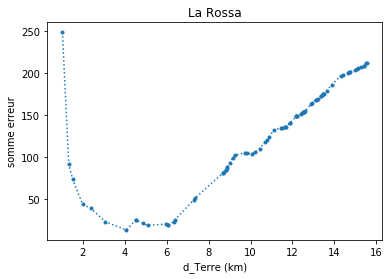

In [21]:
plt.plot( d_span, error_span, '.:'  ); plt.xlabel('d_Terre (km)'); plt.ylabel('somme erreur'); plt.title('%s'%soleil);

In [22]:
def get_best_d( soleil ):
    sorted_name, sorted_dist = get_alldistfromsun( soleil )

    d_span = sorted_dist[1:81]
    error_span = np.array([ get_errorsum( sorted_dist,  d ) for d in d_span ])
    
    i_min =  np.argmin( error_span )
    
    
    return d_span[ i_min ], error_span[ i_min ]

In [23]:
get_best_d( soleil )

(4.0773495689651957, 12.975818250606027)

# Recherche systématique du 'soleil'

## Sommets les plus proches de Grenoble

In [24]:
lat_Gre, lon_Gre = 45.166672, 5.71667 

In [25]:
name_nearGre, dist_nearGre = get_alldistfromcoords( lat_Gre, lon_Gre  )

In [26]:
print ( name_nearGre[:10] )

('Mont Jalla', 'Mont Rachais', 'Les 3 Pucelles', 'Mollard Gargot', 'Moucherotte', 'Le Fournet', 'Les Quatre Seigneurs', 'Le Néron', 'Bellevue', 'Saint-Eynard')


## Boucle

In [27]:
# Calcul :
res = [ (soleil, get_best_d( soleil )) for soleil in name_nearGre[:100] ]

In [28]:
res = sorted( res, key=lambda x:x[1][1] )

In [29]:
# Le top 10 :
for soleil, d_and_error in res[:30]:
    d_Terre_opti, error = d_and_error
    print( '{0:>35}: {1:3.2f}    erreur={2:7.1f}'.format(soleil, d_Terre_opti, error ) )

                        Pic Couttet: 2.95    erreur=    1.4
            Grand Pic de Belledonne: 3.40    erreur=    2.3
                  Le Grand Charnier: 3.39    erreur=    2.4
                 Pointe de Vaudaine: 3.92    erreur=    3.1
                      Grand Replomb: 3.96    erreur=    3.4
             Petite Lance de Domène: 3.88    erreur=    3.5
                       Grand Eulier: 4.08    erreur=    3.5
             Grande Lance de Domène: 3.11    erreur=    3.8
                  Rocher de l'Homme: 3.64    erreur=    4.1
                    Grande Lauzière: 3.99    erreur=    4.3
                          Grand Van: 3.66    erreur=    5.0
                      Sommet Colomb: 2.97    erreur=    5.0
          Pic Central de Belledonne: 2.91    erreur=    5.1
             Petite Lance du Crozet: 3.65    erreur=    5.1
            Pointe de Jasse Bralard: 3.70    erreur=    5.2
                        Le Galeteau: 4.21    erreur=    6.2
                Croix de Chamrousse: 4.2

In [30]:
## Vérif : 
soleil = "L'Écoutoux" #"Grand Pic de Belledonne"
sorted_name, sorted_dist = get_alldistfromsun( soleil )

d_Terre, error = get_best_d( soleil )

print( '{0:>10}  {1:35} {2}   {3}'.format('Planète', 'Sommet',  'Erreur(%)', 'Distance(km)') )
print( '----------------------------------------------------------------' )

for i, n in enumerate( planetes_noms ):
    d_UA = planetes_UA[i]
    pic_proche, erreur, d_reel = findnearest_disp(sorted_name, sorted_dist, d_UA * d_Terre )
    
    alt = get_alt( dicosommets[pic_proche] )
    pic_name = '%s (%im)'%(pic_proche, alt)
    print( '{0:>10}: {1:35} {2:7.2f}    {3:7.1f}'.format(n, pic_name,  erreur, d_reel) )

   Planète  Sommet                              Erreur(%)   Distance(km)
----------------------------------------------------------------
   Mercure: Saint-Eynard (1359m)                   2.94        1.8
     Vénus: Aiguille de Quaix (1143m)              1.02        3.3
     Terre: Chamechaude (2082m)                    0.00        4.5
      Mars: Rochers de Chalves (1845m)             0.33        6.9
     Cérès: La Sure (1643m)                        1.34       12.7
   Jupiter: Pic de l'apparence (2714m)             0.03       23.6
   Saturne: Croix du Nivolet (1547m)               0.03       43.2
    Uranus: Cima dei Fourneaux (3207m)             0.01       87.0
   Neptune: Punta Cialme (2463m)                   0.04      136.4
    Pluton: Corne de Sorebois (2895m)              3.06      173.6


## construit un GeoJson pour géoPortail

http://geojson.org/

https://macwright.org/2015/03/23/geojson-second-bite.html#position

In [31]:
def add_point( coords, name ):
    template = {
      "type": "Feature",
      "geometry": {
        "type": "Point",
        "coordinates": coords
      },
      "properties": {
        "name": name
      }
    }
    return template

In [32]:
data_geo = []
for i, n in enumerate( planetes_noms ):
    d_UA = planetes_UA[i]
    pic_proche, erreur, d_reel = findnearest_disp(sorted_name, sorted_dist, d_UA * d_Terre )
    
    s = dicosommets[ pic_proche ]
    coords = [s['lon'],  s['lat']]
    name = '%s - %s' %(pic_proche, n)
    data_geo.append(  add_point( coords, name )  )
    
# add sun
s = dicosommets[ soleil ]
coords = [  s['lon'], s['lat'] ]
name = '%s - %s' %(soleil, 'Soleil')
data_geo.append(  add_point( coords, name )  )


In [33]:
data_geo

[{'geometry': {'coordinates': [5.7606939, 45.2368246], 'type': 'Point'},
  'properties': {'name': 'Saint-Eynard - Mercure'},
  'type': 'Feature'},
 {'geometry': {'coordinates': [5.7205577, 45.2671104], 'type': 'Point'},
  'properties': {'name': 'Aiguille de Quaix - Vénus'},
  'type': 'Feature'},
 {'geometry': {'coordinates': [5.7881684, 45.2876743], 'type': 'Point'},
  'properties': {'name': 'Chamechaude - Terre'},
  'type': 'Feature'},
 {'geometry': {'coordinates': [5.6975877, 45.2981009], 'type': 'Point'},
  'properties': {'name': 'Rochers de Chalves - Mars'},
  'type': 'Feature'},
 {'geometry': {'coordinates': [5.5973979, 45.2352344], 'type': 'Point'},
  'properties': {'name': 'La Sure - Cérès'},
  'type': 'Feature'},
 {'geometry': {'coordinates': [6.0585091, 45.2401518], 'type': 'Point'},
  'properties': {'name': "Pic de l'apparence - Jupiter"},
  'type': 'Feature'},
 {'geometry': {'coordinates': [5.9655183, 45.6135574], 'type': 'Point'},
  'properties': {'name': 'Croix du Nivolet 

In [34]:
data_geo_collection = {"type":"FeatureCollection",  "features": data_geo }

In [35]:
with open('datageo.json', 'w') as outfile:
    json.dump(data_geo_collection, outfile)

# Pour la suite
- taille des planètes et du soleil à l'échelle
- Calcul de l'horizon, pour réduire le nombre de candidats


In [36]:
import folium

In [42]:
s = dicosommets[ soleil ]
coords_soleil = [   s['lat'], s['lon'] ]

In [56]:
solar_map = folium.Map(location=coords_soleil, zoom_start=12 
                     , tiles='Stamen Terrain')

In [57]:
for i, n in enumerate( planetes_noms ):
    d_UA = planetes_UA[i]
    pic_proche, erreur, d_reel = findnearest_disp(sorted_name, sorted_dist, d_UA * d_Terre )
    
    s = dicosommets[ pic_proche ]
    coords = [s['lat'], s['lon']]
    name = '%s - %s' %(pic_proche, n)
    
    folium.map.Marker(location=coords, popup=name, 
         icon=folium.Icon(color='blue', icon_color='white',icon='fa-globe', prefix='fa') ).add_to(solar_map)
    
    lines = [coords_soleil, coords]
    folium.features.PolyLine(lines).add_to(solar_map)

In [58]:
solar_map

In [38]:
lines = [[45.0136, 6.675], [45.0238, 6.66588]]
folium.features.PolyLine(lines).add_to(map_osm)